In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import ast
from datetime import datetime, timedelta
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import os
# Load your data
file_path1 = "preprocessed_forum_data5.pkl"
stock_data = pd.read_pickle("Finance_data.pkl")

# Display the first few rows to understand the structure



In [2]:








# Start time to measure execution duration
start_time = time.time()

def read_pickle(file_path):
    """
    Read a pickle file.

    Parameters:
        file_path (str): The file path of the pickle file to be read.

    Returns:
        pd.DataFrame: A DataFrame containing the data read from the pickle file.
    """
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        df = None
    except Exception as e:
        print(f"Error reading the pickle file {file_path}:", e)
        df = None
    return df

# Read the dataset from the pickle file
data_df = read_pickle(file_path1)

# Check if the DataFrame is loaded successfully
if data_df is not None:
    # Display the first few rows to inspect the data
    print("First few rows of DataFrame:")
    print(data_df.head())

else:
    print("Data could not be loaded properly.")
forum_data = data_df.copy()

First few rows of DataFrame:
  Created At  Visits  Replies  Users  Post Likes           Timestamp  Likes  \
0 2018-05-01   19000       71     48         545 2018-05-18 11:50:00      0   
1 2018-05-01   19000       71     48         545 2018-05-18 11:55:00      0   
2 2018-05-01   19000       71     48         545 2018-05-18 12:59:00      0   
3 2018-05-01   19000       71     48         545 2018-05-20 05:13:00      0   
4 2018-05-01   19000       71     48         545 2018-05-20 14:26:00      0   

                                             Comment  \
0  ostin comptelia ja nokia osti sen pois seuraav...   
1  mä holdasin comptelia kauan ennen kuin nokia o...   
2  nokia aiheeseen liittyen ostin nokiaa juuri en...   
3  no neste 2017 ylivoimainen oston sattuessa hal...   
4  mä oon ollut reveniossa pitkään ja nokia alkuv...   

                                          Comment ID  \
0  https://keskustelut.inderes.fi/t/onnistumiset-...   
1  https://keskustelut.inderes.fi/t/onnistumise

In [3]:
import ast
import pandas as pd

# Step 1: Handle NaNs and ensure 'Matched Companies Info' is a list
forum_data['Matched Companies Info'] = forum_data['Matched Companies Info'].fillna("[]")

# Step 2: Convert the string representation of lists to actual lists
forum_data['Matched Companies Info'] = forum_data['Matched Companies Info'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Step 3: Extract the first company name from each list
forum_data_exploded = forum_data.explode('Matched Companies Info')

# Extract the company name from the exploded lists
def extract_company(matched_info):
    if isinstance(matched_info, tuple) and len(matched_info) > 1:
        return matched_info[1]
    return None

# Create a new 'Company' column after exploding
forum_data_exploded['Company'] = forum_data_exploded['Matched Companies Info'].apply(extract_company)

# Check to ensure rows have been separated correctly


In [4]:
forum_data_exploded.head(20)

,Created At,Visits,Replies,Users,Post Likes,Timestamp,Likes,Comment,Comment ID,Matched Companies Info,Sentiment,Company
0,2018-05-01,19000,71,48,545,2018-05-18 11:50:00,0,ostin comptelia ja nokia osti sen pois seuraav...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Nokia, Nokia Corporation, True)",NEUTRAL,Nokia Corporation
1,2018-05-01,19000,71,48,545,2018-05-18 11:55:00,0,mä holdasin comptelia kauan ennen kuin nokia o...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Nokia, Nokia Corporation, True)",NEUTRAL,Nokia Corporation
2,2018-05-01,19000,71,48,545,2018-05-18 12:59:00,0,nokia aiheeseen liittyen ostin nokiaa juuri en...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Nokia, Nokia Corporation, True)",NEUTRAL,Nokia Corporation
3,2018-05-01,19000,71,48,545,2018-05-20 05:13:00,0,no neste 2017 ylivoimainen oston sattuessa hal...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Neste, Neste Oyj, True)",NEUTRAL,Neste Oyj
4,2018-05-01,19000,71,48,545,2018-05-20 14:26:00,0,mä oon ollut reveniossa pitkään ja nokia alkuv...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Nokia, Nokia Corporation, True)",POSITIVE,Nokia Corporation
4,2018-05-01,19000,71,48,545,2018-05-20 14:26:00,0,mä oon ollut reveniossa pitkään ja nokia alkuv...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Reveniossa, Revenio Group Oyj, True)",POSITIVE,Revenio Group Oyj
5,2018-05-01,19000,71,48,545,2019-09-12 15:25:00,0,huomasin juuri salkun olevan athlukemissa mets...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Sampoa, Sampo Oyj, True)",NEUTRAL,Sampo Oyj
6,2018-05-01,19000,71,48,545,2019-09-29 20:40:00,0,kyllä mun mielestä lapsen salkussa jossa summa...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(nokia, Nokia Corporation, True)",NEUTRAL,Nokia Corporation
7,2018-05-01,19000,71,48,545,2019-09-29 21:26:00,0,okei mennyt kyllä kuin oppikirjassa kun noinki...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Talenomiin, Talenom Oyj, True)",POSITIVE,Talenom Oyj
8,2018-05-01,19000,71,48,545,2020-08-14 10:11:00,0,alkukeväästä nohon rahat vaihdettu remedyyn yl...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(NoHon, NoHo Partners Oyj, True)",NEUTRAL,NoHo Partners Oyj


In [5]:
forum_data_exploded['Created At'] = pd.to_datetime(forum_data_exploded['Created At'], errors='coerce')
forum_data_exploded['Timestamp'] = pd.to_datetime(forum_data_exploded['Timestamp'], errors='coerce')

# Extract year and month
forum_data_exploded['Year'] = forum_data_exploded['Created At'].dt.year
forum_data_exploded['Month'] = forum_data_exploded['Created At'].dt.month

forum_data_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12598 entries, 0 to 10164
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Created At              12578 non-null  datetime64[ns]
 1   Visits                  12598 non-null  int64         
 2   Replies                 12598 non-null  int64         
 3   Users                   12598 non-null  int64         
 4   Post Likes              12598 non-null  int64         
 5   Timestamp               12598 non-null  datetime64[ns]
 6   Likes                   12598 non-null  int64         
 7   Comment                 12598 non-null  object        
 8   Comment ID              12598 non-null  object        
 9   Matched Companies Info  12598 non-null  object        
 10  Sentiment               12598 non-null  object        
 11  Company                 12598 non-null  object        
 12  Year                    12578 non-null  float6

  Created At    Visits  Replies  Users  Post Likes           Timestamp  Likes  \
0 2018-05-01     19000       71     48         545 2019-09-12 15:25:00      0   
1 2018-11-01  21000000     6100    740       74200 2019-09-01 10:23:00      0   
2 2018-11-01  21000000     6100    740       74200 2019-09-01 16:50:00      0   
3 2018-11-01  21000000     6100    740       74200 2019-09-02 18:51:00      0   
4 2018-11-01  21000000     6100    740       74200 2019-09-02 19:14:00      0   

                                             Comment  \
0  huomasin juuri salkun olevan athlukemissa mets...   
1  juu kone on hissillä ylimmässä kerroksessa mit...   
2  hyvä pointti nordeasta putsattuna sampo ei eri...   
3  httpswwwtaalerivarainhoitocomajankohtaistasijo...   
4  sampo suomalaisen pääoman ikoni ei kriisiydy e...   

                                          Comment ID  \
0  https://keskustelut.inderes.fi/t/onnistumiset-...   
1  https://keskustelut.inderes.fi/t/sampo-vakuutt...   
2  https

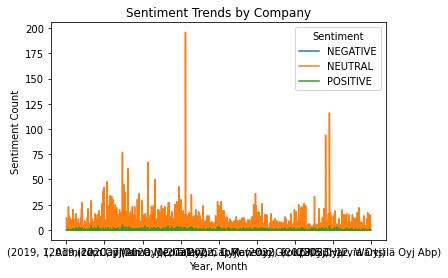

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Timestamp' in forum data and 'Date' in stock data are in datetime format
forum_data_exploded['Timestamp'] = pd.to_datetime(forum_data_exploded['Timestamp'], errors='coerce')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

# Create 'Year' and 'Month' columns from 'Timestamp' and 'Date'
forum_data_exploded['Year'] = forum_data_exploded['Timestamp'].dt.year
forum_data_exploded['Month'] = forum_data_exploded['Timestamp'].dt.month
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month

# Strip and align 'Company' columns in both datasets
forum_data_exploded['Company'] = forum_data_exploded['Company'].str.strip()
stock_data['Company'] = stock_data['Company'].str.strip()

# Merge on 'Year', 'Month', and 'Company'
merged_data = pd.merge(
    forum_data_exploded,
    stock_data,
    left_on=['Year', 'Month', 'Company'],
    right_on=['Year', 'Month', 'Company'],
    how='inner'
)

# Check the structure of the merged data
print(merged_data.head())

# Example: Analyze sentiment counts by company over time
company_sentiment = merged_data.groupby(['Year', 'Month', 'Company', 'Sentiment']).size().unstack(fill_value=0)

# Plot sentiment trends for a specific company
company_sentiment.plot(kind='line', title='Sentiment Trends by Company')
plt.xlabel('Year, Month')
plt.ylabel('Sentiment Count')
plt.show()


In [21]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11837 entries, 0 to 11836
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Created At              11837 non-null  datetime64[ns]
 1   Visits                  11837 non-null  int64         
 2   Replies                 11837 non-null  int64         
 3   Users                   11837 non-null  int64         
 4   Post Likes              11837 non-null  int64         
 5   Timestamp               11837 non-null  datetime64[ns]
 6   Likes                   11837 non-null  int64         
 7   Comment                 11837 non-null  object        
 8   Comment ID              11837 non-null  object        
 9   Matched Companies Info  11837 non-null  object        
 10  Sentiment               11837 non-null  object        
 11  Company                 11837 non-null  object        
 12  Year                    11837 non-null  int64 

In [14]:
# Filter forum data for Nokia Corporation
nokia_forum_data = forum_data_exploded[forum_data_exploded['Company'].str.contains('Nokia Corporation', case=False, na=False)]

# Filter stock data for Nokia Corporation
nokia_stock_data = stock_data[stock_data['Company'].str.contains('Nokia Corporation', case=False, na=False)]
# Define the start and end dates for 2023
start_date_2023 = pd.Timestamp('2023-01-01')
end_date_2023 = pd.Timestamp('2023-12-31')

# Filter forum data for 2023
nokia_forum_2023 = nokia_forum_data[(nokia_forum_data['Timestamp'] >= start_date_2023) &
                                   (nokia_forum_data['Timestamp'] <= end_date_2023)]

# Filter stock data for 2023
nokia_stock_2023 = nokia_stock_data[(nokia_stock_data['Date'] >= start_date_2023) &
                                   (nokia_stock_data['Date'] <= end_date_2023)]


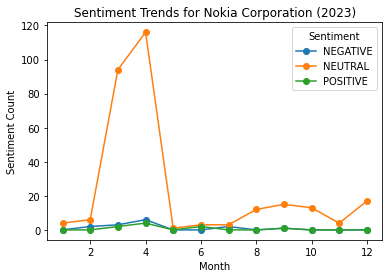

In [15]:
# Group sentiment data by month for 2023
nokia_sentiment_trends_2023 = nokia_forum_2023.groupby(['Month', 'Sentiment']).size().unstack(fill_value=0)

# Plot sentiment trends for Nokia Corporation in 2023
nokia_sentiment_trends_2023.plot(kind='line', title='Sentiment Trends for Nokia Corporation (2023)', marker='o')
plt.xlabel('Month')
plt.ylabel('Sentiment Count')
plt.show()


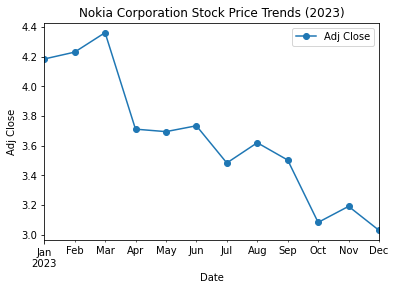

In [17]:
# Plot stock prices for Nokia Corporation in 2023
nokia_stock_2023.plot(x='Date', y='Adj Close', kind='line', title='Nokia Corporation Stock Price Trends (2023)', marker='o')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()


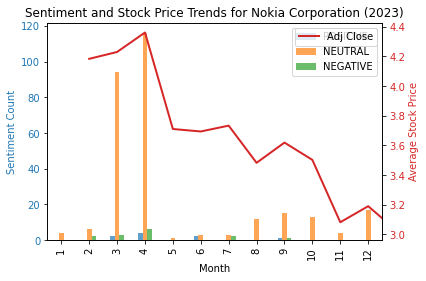

In [20]:
# Merge sentiment and stock price trends for 2023
nokia_merged_2023 = pd.merge(
    nokia_sentiment_trends_2023,
    nokia_stock_2023.groupby(['Month'])['Adj Close'].mean(),
    on='Month'
)

# Visualize the comparison between sentiment and stock price trends
fig, ax1 = plt.subplots()

# Plot sentiment trends
ax1.set_xlabel('Month')
ax1.set_ylabel('Sentiment Count', color='tab:blue')
nokia_merged_2023.plot(kind='bar', y=['POSITIVE', 'NEUTRAL', 'NEGATIVE'], ax=ax1, alpha=0.7)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot stock price trends
ax2 = ax1.twinx()
ax2.set_ylabel('Average Stock Price', color='tab:red')
nokia_merged_2023.plot(kind='line', y='Adj Close', ax=ax2, color='tab:red', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Sentiment and Stock Price Trends for Nokia Corporation (2023)')
plt.show()


In [22]:
# Compute the correlation between sentiment and stock prices
sentiment_columns = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']
correlation_results = nokia_merged_2023[sentiment_columns + ['Adj Close']].corr()

print("Correlation between sentiment and stock prices:")
print(correlation_results['Adj Close'])


Correlation between sentiment and stock prices:
POSITIVE     0.269216
NEUTRAL      0.304686
NEGATIVE     0.353782
Adj Close    1.000000
Name: Adj Close, dtype: float64


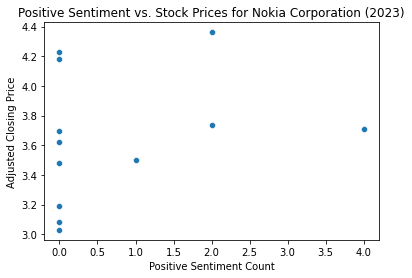

In [23]:
import seaborn as sns

# Scatter plot for positive sentiment and stock prices
sns.scatterplot(data=nokia_merged_2023, x='POSITIVE', y='Adj Close')
plt.title("Positive Sentiment vs. Stock Prices for Nokia Corporation (2023)")
plt.xlabel("Positive Sentiment Count")
plt.ylabel("Adjusted Closing Price")
plt.show()


In [24]:
# Find months with spikes in positive sentiment
sentiment_spikes = nokia_sentiment_trends_2023['POSITIVE'] > nokia_sentiment_trends_2023['POSITIVE'].mean() * 2

print("Months with significant positive sentiment spikes:")
print(sentiment_spikes[sentiment_spikes == True])


Months with significant positive sentiment spikes:
Month
3    True
4    True
6    True
Name: POSITIVE, dtype: bool


In [26]:
# Check for duplicate indices in the DataFrame
print("Forum Data Duplicates:", nokia_forum_2023.index.duplicated().any())

# Check for duplicate indices in the sentiment spikes Series
print("Sentiment Spikes Duplicates:", sentiment_spikes.index.duplicated().any())


Forum Data Duplicates: False
Sentiment Spikes Duplicates: False


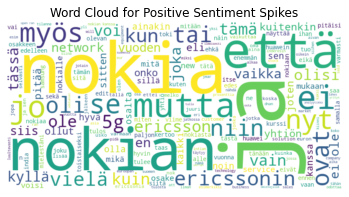

In [27]:
# Combine all comments for months with sentiment spikes
spike_months = sentiment_spikes[sentiment_spikes].index  # Get the months with true spikes
positive_spike_comments = " ".join(nokia_forum_2023[nokia_forum_2023['Month'].isin(spike_months)]['Comment'])

# Create a word cloud with the combined comments
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_spike_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Sentiment Spikes")
plt.show()


In [36]:
stop_words = ['nokian', 'nokia', 'ja', 'tai', 'että', 'on', 'ei', 'mutta' , 'the', 'jo' , 'and', 'of', 'to', 'in', 'myös', 'jos', 'se','nyt','ovat','ole']

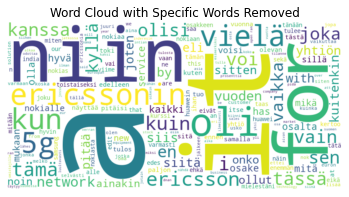

In [37]:
from wordcloud import WordCloud

# Create a word cloud excluding specific words
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=set(stop_words)).generate(positive_spike_comments)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud with Specific Words Removed")
plt.show()


In [9]:
# Attempt to convert "Created At" to datetime
forum_data['Created At'] = pd.to_datetime(forum_data['Created At'], errors='coerce')

# After converting, check for any nulls (indicating failed conversion)
if forum_data['Created At'].isnull().any():
    print("Some dates could not be converted. Investigate further.")
else:
    print("All dates converted successfully.")


Some dates could not be converted. Investigate further.


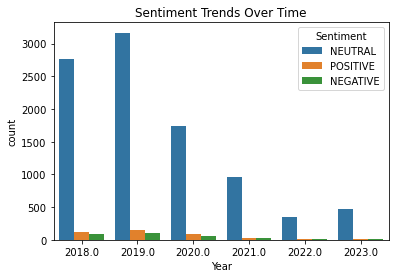

In [10]:
# Extract the year from the "Created At" column
forum_data['Year'] = forum_data['Created At'].dt.year

# Analyze sentiment trends over the years
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=forum_data, x='Year', hue='Sentiment')
plt.title("Sentiment Trends Over Time")
plt.show()


In [11]:
# First, convert "Matched Companies Info" to ensure compatibility with stock data
forum_data['Matched Companies Info'] = forum_data['Matched Companies Info'].str.lower()

# Merge forum data with stock data
merged_data = pd.merge(forum_data, stock_data, left_on=['Matched Companies Info', 'Created At'], right_on=['Company', 'Date'], how='inner')

# Check the structure of merged data
print(merged_data.head())

# Calculate the change in stock price
merged_data['Price Change'] = merged_data['Close'].diff()

# Scatter plot of sentiment vs. price change
sns.scatterplot(data=merged_data, x='Sentiment', y='Price Change', hue='Sentiment', palette='coolwarm')
plt.title("Sentiment vs. Stock Price Change")
plt.show()

# Calculate correlation between sentiment and price changes
correlation = merged_data['Sentiment'].astype('category').cat.codes.corr(merged_data['Price Change'])
print("Correlation between Sentiment and Price Change:", correlation)


ValueError: You are trying to merge on float64 and object columns. If you wish to proceed you should use pd.concat

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'Timestamp' is in datetime format
forum_data_exploded['Timestamp'] = pd.to_datetime(forum_data_exploded['Timestamp'], errors='coerce')

# Extract the year from 'Timestamp'
forum_data_exploded['Year'] = forum_data_exploded['Timestamp'].dt.year

# Plot the distribution of comments by year
sns.countplot(data=forum_data_exploded, x='Year', order=sorted(forum_data_exploded['Year'].unique()))

plt.title("Number of Comments per Year")
plt.xlabel("Year")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()



In [ ]:
merged_data.info()

In [ ]:
merged_data.head()

In [ ]:
# Filter the merged data for a specific company, e.g., "Nokia Corporation"
company_name = 'Nokia Corporation'
filtered_data = merged_data[merged_data['Company'] == company_name]

# Ensure 'Sentiment' is converted to numerical codes
filtered_data['Sentiment_Code'] = filtered_data['Sentiment'].astype('category').cat.codes

# Calculate price change between consecutive rows
filtered_data['Price Change'] = filtered_data['Close'].diff()

# Select features for correlation analysis
correlation_features = ['Price Change', 'Visits', 'Replies', 'Users', 'Post Likes', 'Sentiment_Code']

# Calculate the correlation matrix
correlation_matrix = filtered_data[correlation_features].corr()

# Plot the correlation matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f"Correlation Matrix for {company_name}")
plt.show()



In [ ]:
import numpy as np
lags = range(1, 8)  # Test lags from 1 to 7 days
correlations = []

for lag in lags:
    # Shift price change to create lag
    filtered_data[f'Price Change Lag {lag}'] = filtered_data['Price Change'].shift(-lag)
    correlation = filtered_data['Sentiment_Code'].corr(filtered_data[f'Price Change Lag {lag}'])
    correlations.append((lag, correlation))

# Plot lagged correlations
lagged_df = pd.DataFrame(correlations, columns=['Lag', 'Correlation'])
sns.lineplot(data=lagged_df, x='Lag', y='Correlation', marker='o')
plt.title("Correlation of Sentiment with Lagged Price Change")
plt.show()
